# Create models from *Ergo* data
This notebook contains the code for models used to predict the *Ergo* data. See the report [here](https://git.cs.sun.ac.za/Computer-Science/rw771/2022/26723077-TG7-doc) or the source code behind the data [here](https://git.cs.sun.ac.za/Computer-Science/rw771/2022/26723077-TG7-src).

### Items to explore

- What is the optimal number of PCs for model performance?
- Which is the optimal dimensionality reduction method: tSNE, Autoencoder, PCA?
- Compare different model types: Random Forest, SVM, NN, Nïeve Bayes, Quadratic Discriminent Analysis

## Imports and constants

In [151]:
from common_utils import *

from matplotlib import cm
from time import time

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Distributions
from sklearn.utils.fixes import loguniform

In [152]:
USE_W_AND_B = False

## Preprocessing data

In [165]:
# Get some metadata and descriptions about the gestures
gesture_info = get_gesture_info()

# Get a hashmap of the form `directory` => [`file1`, `file2`, ...]
dir_files = get_dir_files()

# Print out all the gestures that we've got data for
format_string = "\n- ".join([
    f'{k}: {gesture_info.get(k, {}).get("description", "<No description>"):<40} ({len(v)} files)' 
    for k,v in dir_files.items()
])
print(f'The following gestures have data recorded for them:\n- {format_string}')

The following gestures have data recorded for them:
- gesture0001: Left hand thumb IP flexion               (556 files)
- gesture0002: Left hand index finger PIP flexion       (511 files)
- gesture0003: Left hand middle finger PIP flexion      (591 files)
- gesture0004: Left hand ring finger PIP flexion        (481 files)
- gesture0005: Left hand little finger PIP flexion      (431 files)
- gesture0006: Right hand thumb IP flexion              (495 files)
- gesture0007: Right hand index finger PIP flexion      (608 files)
- gesture0008: Right hand middle finger PIP flexion     (501 files)
- gesture0009: Right hand ring finger PIP flexion       (386 files)
- gesture0010: Right hand little finger PIP flexion     (501 files)
- gesture0011: Left hand thumb IP extension             (531 files)
- gesture0012: Left hand index finger PIP extension     (542 files)
- gesture0013: Left hand middle finger PIP extension    (595 files)
- gesture0014: Left hand ring finger PIP extension      (547 fil

## Read in the data to an `np.array`

TODO: Convert this into a method in `common_utils.py`

In [166]:
n_sensors, n_timesteps = 30, 40

# Exclude all classes which do not have at least 300 observations
n_classes = len([d for d,fs in dir_files.items() if len(fs) > 300])
n_obs = sum([len(fs) for d, fs in dir_files.items() if len(fs) > 300])
print(f'{n_classes=}, {n_obs=}')

# Create arrays to store the observations and labels
X = np.zeros((n_obs, n_sensors * n_timesteps))
y = np.zeros((n_obs,))
# Also keep track of the paths from which each observation originated
paths = []

# Create hashmaps to easily convert from and from indexes (0, 1, 2, 3, ...) 
# and gestures ('gesture0001', 'gesture0002', ...)
idx_to_gesture = {}
gesture_to_idx = {}

# The `obs_idx` increments with every observation
obs_idx = 0
# The `label_idx` increments with every label iff 
# there's > 300 observations for that label
label_idx = 0

# Iterate over every gesture
for gesture_index, filenames in dir_files.items():
    if len(filenames) > 300:
        # Populate the idx <-> gesture mapping
        idx_to_gesture[label_idx] = gesture_index
        gesture_to_idx[gesture_index] = label_idx
        
        
        print(f"Processing {gesture_index} ({gesture_info[gesture_index]['desc']})")
        # Iterate over every observation for the current gesture
        for file in filenames:
            # Keep track of the path for bookkeeping purposes
            paths.append(f'../gesture_data/train/{gesture_index}/{file}')
            # Read in the raw sensor data. Normalisation is done later on via sklearn
            df = read_to_df(paths[-1], normalise=False)
            # Make sure the data is the correct shape
            if df.shape != (n_timesteps, n_sensors):
                print(df)
            # Save observation as a plain `np.array` in the X array
            X[obs_idx] = df.to_numpy().T.flatten()
            # If there are any NaNs, the observation is probably 
            # incomplete and should be removed
            if np.any(np.isnan(X[obs_idx])):
                print(f'rm {paths[-1]}')
            # Save the label of the current observation
            y[obs_idx] = label_idx
            
            obs_idx += 1
        label_idx += 1
        
print('done')

n_classes=21, n_obs=11301
Processing gesture0001 (l1-ip-flx)
Processing gesture0002 (l2-pip-flx)
Processing gesture0003 (l3-pip-flx)
Processing gesture0004 (l4-pip-flx)
Processing gesture0005 (l5-pip-flx)
Processing gesture0006 (r1-ip-flx)
Processing gesture0007 (r2-pip-flx)
Processing gesture0008 (r3-pip-flx)
Processing gesture0009 (r4-pip-flx)
Processing gesture0010 (r5-pip-flx)
Processing gesture0011 (l1-ip-ext)
Processing gesture0012 (l2-pip-ext)
Processing gesture0013 (l3-pip-ext)
Processing gesture0014 (l4-pip-ext)
Processing gesture0015 (l5-pip-ext)
Processing gesture0016 (r1-ip-ext)
Processing gesture0017 (r2-pip-ext)
Processing gesture0018 (r3-pip-ext)
Processing gesture0019 (r4-pip-ext)
Processing gesture0020 (r5-pip-ext)
Processing gesture0255 (no mvmt)
done


### Train-test split and scale the data

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Reduce dimensionality via PCA

In [172]:
%%time
n_components = 10

print(f'Fitting PCA with {n_components} components on {X_train.shape[0]} observations')
pca = PCA(
    n_components=n_components,
    svd_solver="randomized", 
    whiten=True
).fit(X_train)

print(f"PCA explained {100*sum(pca.explained_variance_ratio_):.2f}% of the variance with {n_components} PCs")

# PCA-transform the input test and train data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Fitting PCA with 10 components on 8481 observations
PCA explained 38.15% of the variance with 10 PCs
CPU times: user 3.89 s, sys: 455 ms, total: 4.35 s
Wall time: 479 ms


## Train multiple models on the data
### Each model is defined in its own cell

In [257]:
models = []

---
Support Vector Machine
- Time taken: 7.731s
- Best performing model
`SVC(C=35891.14381335473, class_weight='balanced', gamma=0.057667711437645666)`
- Score: train: 0.9896, test: 0.9901

In [258]:
models.append(
    (SVC(kernel="rbf", class_weight="balanced"), {
        "C": loguniform(1e3, 1e5),
        "gamma": loguniform(1e-4, 1e-1),
    })
)

---
Linear Support Vector Machine

- Time taken: 367.828s
- Best performing model: SVC(C=1284.851851420933, class_weight='balanced', kernel='linear')
- Score: train: 0.9780, test: 0.9784

In [ ]:
models.append(
    (SVC(kernel="linear", class_weight="balanced"), {
        "C": loguniform(1e3, 1e5),
    })
)

---
K-Nearest Neighbours
- Time taken: 0.820s
- Best performing model
`KNeighborsClassifier(algorithm='ball_tree', n_neighbors=21)`
- Score: train: 0.9849, test: 0.9851

In [259]:
models.append(
    (KNeighborsClassifier(n_neighbors=n_classes), {
        "algorithm": ['ball_tree', 'kd_tree', 'brute'],
    })
)

---
Ada Boost
- Time taken: 268.507s
- Best performing model: AdaBoostClassifier(learning_rate=0.20109497487437183, n_estimators=792)
- Score: train: 0.7856, test: 0.7867


In [ ]:
models.append(
    (AdaBoostClassifier(), {
        'n_estimators': range(10, 1000),
        'learning_rate': np.linspace(1e-4, 2, num=200),
    })
)

---
Decision Tree
- Time taken: 1.136s
- Best performing model
`DecisionTreeClassifier(class_weight='balanced', max_depth=186,
                       min_samples_split=0.26530612244897955)`
- Score: train: 0.4396, test: 0.4712

In [248]:
models.append(
    (DecisionTreeClassifier(class_weight="balanced"), {
        'max_depth': range(1, 200),
        'min_samples_split': np.linspace(0, 1),
    })
)

---
Random Forest
- Time taken: 31.299s
- Best performing model

`RandomForestClassifier(max_depth=187, max_features=0.836734693877551,
                       min_samples_split=0.16326530612244897, n_estimators=176)`
- Score: train: 0.6110, test: 0.6095

In [249]:
models.append(
    (RandomForestClassifier(), {
        'n_estimators': range(10, 500), 
        'max_depth': range(1, 200), 
        'max_features': np.linspace(0, 1),
        'min_samples_split': np.linspace(0, 1),
    })
)

---

Multi-layer Perceptron
- Time taken: 484.457s
- Best performing model

```MLPClassifier(activation='tanh', alpha=2.8761865563186644e-05,
              hidden_layer_sizes=(400, 200), max_iter=1000)```
- Score: train: 0.9914, test: 0.9919

In [262]:
models.append(
    (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(100), (200), (400), (100, 50), (200, 100), (400, 200), 
                               (100, 50, 25), (200, 100, 50), (400, 200, 100)],
        'activation' : ['logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'adam'],
        'alpha': loguniform(1e-6, 1e-2),
    })
)

---
Gaussian Naïve Bayes
- Time taken: 0.031s
- Best performing model: GaussianNB()
- Score: train: 0.9255, test: 0.9264

In [261]:
models.append((GaussianNB(), {}))

---
Quadratic Discriminant Analysis
- Time taken: 0.040s
- Best performing model: QuadraticDiscriminantAnalysis()
- Score: train: 0.9854, test: 0.9837

In [260]:
models.append((QuadraticDiscriminantAnalysis(), {}))

---
Now actually evaluate the models

In [263]:
clfs = []
for model, param_grid in models:
    print(f'\nTraining {model}')
    start = time()
    clf = RandomizedSearchCV(
        model, param_grid, n_iter=10
    )
    clf = clf.fit(X_train_pca, y_train)
    print(f'- Time taken: {time() - start:.3f}s\n- Best performing model\n`{clf.best_estimator_}`\n- Score: train: {clf.best_score_:.4f}, test: {clf.score(X_test_pca, y_test):.4f}')
    clfs.append(clf.best_estimator_)

Training SVC(class_weight='balanced')
- Time taken: 7.872s
- Best performing model
`SVC(C=19175.550263176316, class_weight='balanced', gamma=0.007963491133367192)`
- Score: train: 0.9908, test: 0.9880
Training KNeighborsClassifier(n_neighbors=21)


/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


- Time taken: 0.804s
- Best performing model
`KNeighborsClassifier(algorithm='ball_tree', n_neighbors=21)`
- Score: train: 0.9849, test: 0.9851
Training QuadraticDiscriminantAnalysis()
- Time taken: 0.025s
- Best performing model
`QuadraticDiscriminantAnalysis()`
- Score: train: 0.9854, test: 0.9837
Training GaussianNB()
- Time taken: 0.020s
- Best performing model
`GaussianNB()`
- Score: train: 0.9255, test: 0.9264
Training MLPClassifier(alpha=1, max_iter=1000)


/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


- Time taken: 484.457s
- Best performing model
`MLPClassifier(activation='tanh', alpha=2.8761865563186644e-05,
              hidden_layer_sizes=(400, 200), max_iter=1000)`
- Score: train: 0.9914, test: 0.9919


### Get detailed analyses of the trained models

Test set results for SVC
              precision    recall  f1-score   support

 gesture0001       1.00      1.00      1.00       146
 gesture0002       0.99      1.00      1.00       120
 gesture0003       1.00      1.00      1.00       165
 gesture0004       1.00      0.99      1.00       120
 gesture0005       1.00      1.00      1.00       107
 gesture0006       1.00      0.99      1.00       125
 gesture0007       1.00      1.00      1.00       152
 gesture0008       1.00      0.99      1.00       127
 gesture0009       1.00      1.00      1.00       108
 gesture0010       1.00      1.00      1.00       133
 gesture0011       0.95      1.00      0.98       124
 gesture0012       0.98      0.94      0.96       146
 gesture0013       0.99      0.99      0.99       145
 gesture0014       0.93      0.97      0.95       133
 gesture0015       0.96      0.97      0.96       124
 gesture0016       1.00      0.99      0.99       136
 gesture0017       0.98      0.96      0.97       129
 g

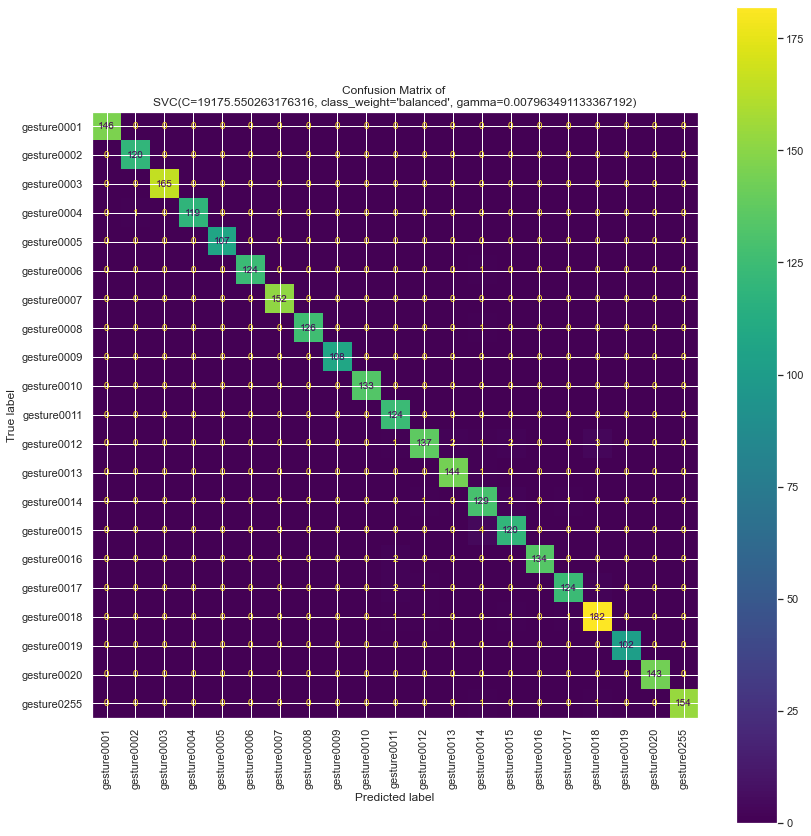

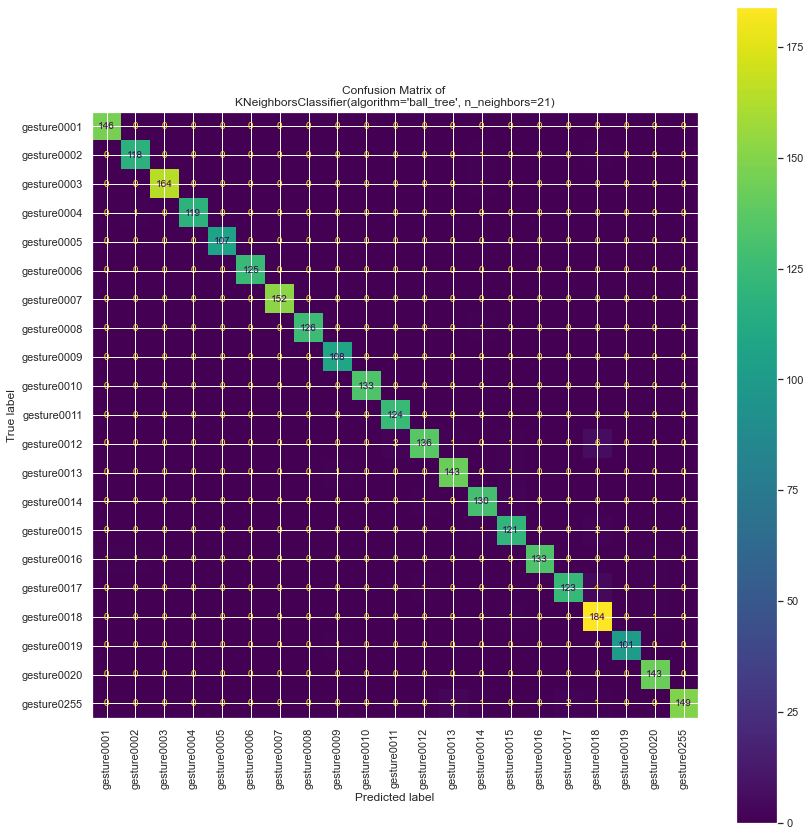

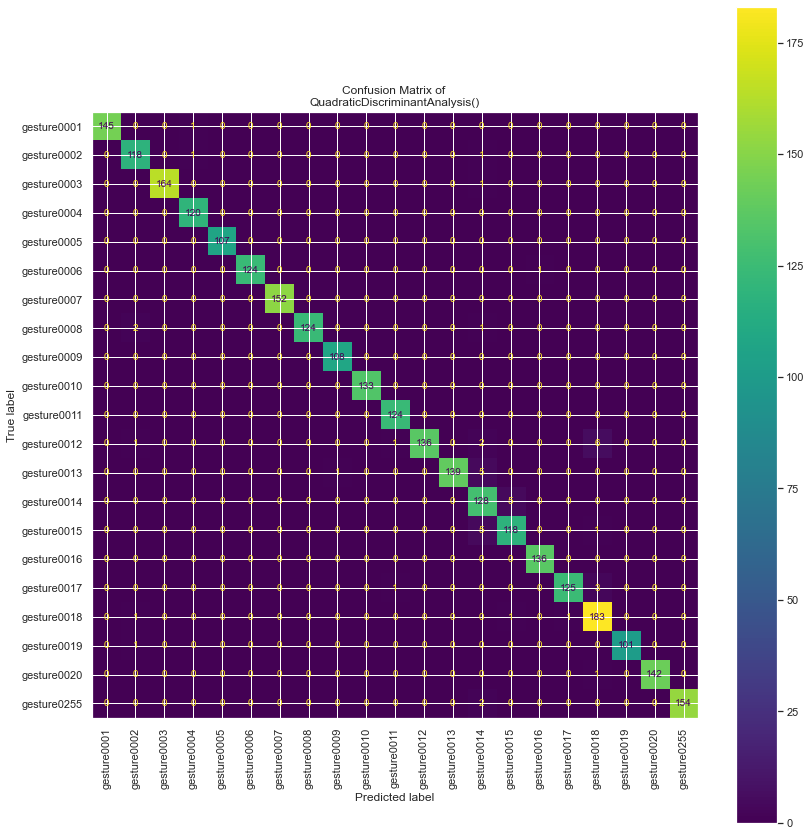

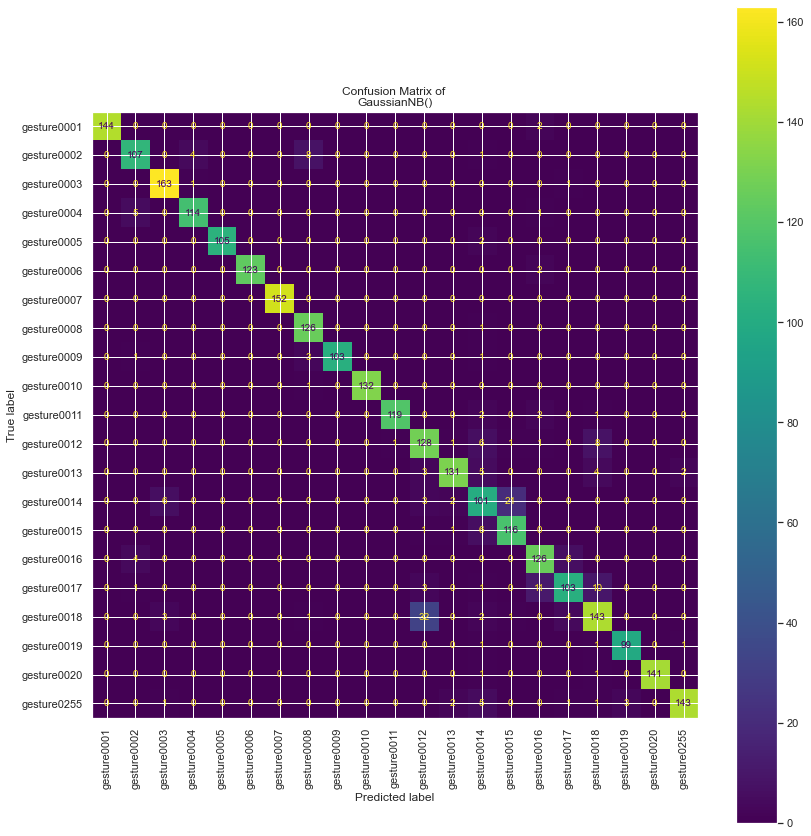

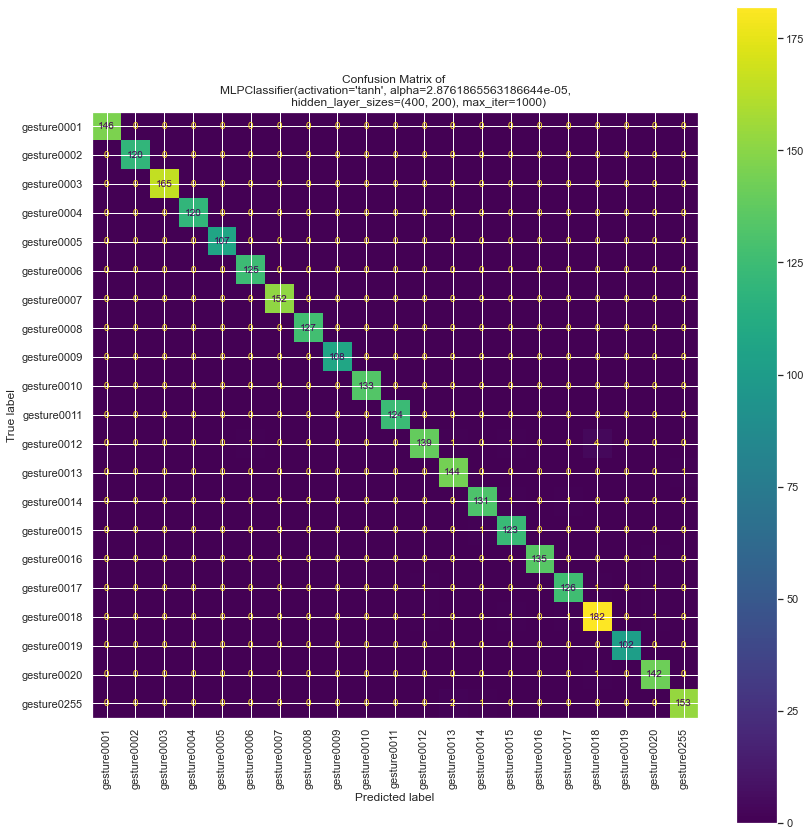

In [264]:
for clf in clfs:
    y_pred = clf.predict(X_test_pca)
    clf_name = f'{str(type(clf))}'.split('.')[-1][:-2]

    print(f"Test set results for {clf_name}")
    print(classification_report(y_test, y_pred, target_names=gesture_to_idx.keys()))

    fig, ax = plt.subplots(figsize=(12,12))
    ConfusionMatrixDisplay.from_estimator(
        clf, 
        X_test_pca, 
        y_test, 
        display_labels=gesture_to_idx.keys(), 
        xticks_rotation="vertical",
        ax=ax,
    )
    plt.title(f'Confusion Matrix of \n{clf}')
    plt.tight_layout()

    plt.savefig(f'imgs/conf_mat_{clf}.pdf')

## Plot 2-component PCA to assess separation

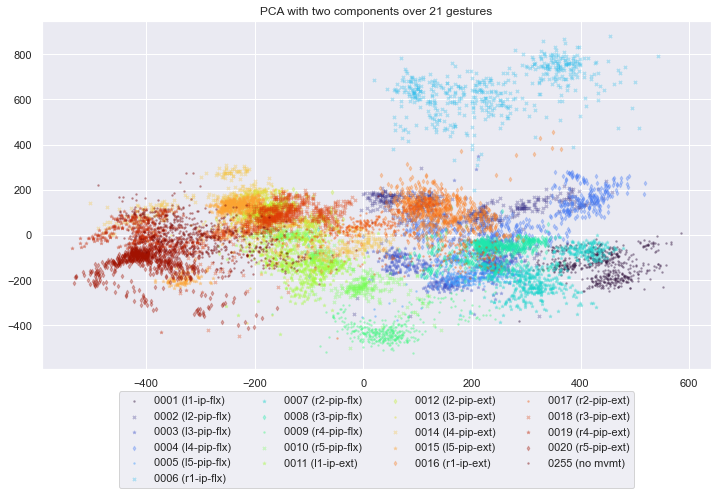

In [193]:
# PCA can be either 2D or 3D
PLOT_2D = True

# Transform the data via PCA. Either 2 or 3 components are used
pca = PCA(n_components=(2 if PLOT_2D else 3))
X_r = pca.fit(X).transform(X)

# Each observation gets a different colour on the scatter plot, and
# similar colours get different markers to better differentiate them
colours = cm.get_cmap('turbo', n_classes)
markers = ['.', 'x', '*', 'd']


if PLOT_2D:
    # Use 2D subplots
    fig, ax = plt.subplots(figsize=(12,8))
else:
    # Use 3D subplots
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

# Optionally also plot the observation indices along with the points.
# This helps when removing outliers, but increases the amount of clutter
# if PLOT_2D:
#     for i, yi in enumerate(y):
#         ax.annotate(
#             i, 
#             (X_r[i, 0], X_r[i, 1]),
#             color=colours(yi/n_classes),
#             size=5,
#             alpha=0.5,
#         )

# Iterate over each label/gesture
for i, label_idx in enumerate(idx_to_gesture.keys()):
    # Args either has 2 items (if 2D) or 3 (if 3D)
    args = [
        X_r[y == label_idx, 0], 
        X_r[y == label_idx, 1],
    ]
    if not PLOT_2D:
        args.append(X_r[y == label_idx, 2])
    
    # Get a shortened version of the gesture index for the legend
    gesture_idx = idx_to_gesture[label_idx].replace('gesture', '')
    # Get the short gesture description for the legend
    gesture_desc = gesture_info[idx_to_gesture[label_idx]]["desc"]
    
    # Actually plot the points, either in 2 or 3 dimensions
    ax.scatter(
        *args,
        color=colours(label_idx/n_classes),
        alpha=0.3,
        s=10,
        marker=markers[label_idx % 4],
        label=f'{gesture_idx} ({gesture_desc})'
    )

# ----------------------------------------------------------------
#
#   modified from https://stackoverflow.com/a/4701285/14555505
#
# Shrink current axis's height by 10% on the bottom so the legend will fit
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.80])
# Put a legend below current axis in the newly made space
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
# ----------------------------------------------------------------

# Give the plot a title and save it
plt.title(f"PCA with {'two' if PLOT_2D else 'three'} components over {n_classes} gestures")
plt.savefig(f'imgs/{2 if PLOT_2D else 3}_pca_{n_classes}_classes_{n_obs}_obs.pdf')

In [144]:
%matplotlib inline
@interact(idx='0')
def plot_from_index(idx='0'):
    if len(idx) == 0:
        return
    idx = int(idx)
    gesture_idx = idx_to_gesture[y[idx]]
    plot_raw_gesture(
        X[idx], 
        f'{gesture_idx}: {gesture_info[gesture_idx]["description"]}\n{paths[idx]}'
    )
    print(f'{gesture_info[gesture_idx]["description"]}')
    print('rm ' + '/'.join(paths[idx].split('/')[3:]))

interactive(children=(Text(value='0', description='idx'), Output()), _dom_classes=('widget-interact',))

In [37]:
xpow = list(range(0, 11))
x_vals = [2**xipow for xipow in xpow]
y_vals = []

for xi in x_vals:
    print(f'fitting PCA with {xi} components', end='')
    pca = PCA(n_components=xi)
    X_r = pca.fit(X).transform(X)
    y_vals.append(sum(pca.explained_variance_ratio_))
    print(f": Explained variance: {y_vals[-1]}")
    
    
plt.plot(
    x_vals,y_vals
)
plt.show()

fitting PCA with 1 components: Explained variance: 0.15151829887117524
fitting PCA with 2 components: Explained variance: 0.24332011763493158
fitting PCA with 4 components: Explained variance: 0.31211674214687185
fitting PCA with 8 components: Explained variance: 0.37807615008574896
fitting PCA with 16 components: Explained variance: 0.4440771481896294
fitting PCA with 32 components: Explained variance: 0.5113496113913644
fitting PCA with 64 components: Explained variance: 0.5976681010845858
fitting PCA with 128 components: Explained variance: 0.7155955158802236
fitting PCA with 256 components: Explained variance: 0.8232610153037475
fitting PCA with 512 components: Explained variance: 0.9137741473809469
fitting PCA with 1024 components: Explained variance: 0.9909384455315083


## Train TensorFlow neural network

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
if USE_W_AND_B:
    import wandb
    from wandb.keras import WandbCallback

In [6]:
config = {
    "epochs": 10,
    "batch_size": 32,
    "resample_period": 25,
}
if USE_W_AND_B:
    wandb.init(project="ergo", entity="beyarkay")
    wandb.config = config

In [7]:
# https://www.tensorflow.org/tutorials/load_data/csv#multiple_files_2
dirs = sorted(list(dir_files.keys()))

list_ds = tf.data.Dataset.list_files('../gesture_data/train/*/*.txt')

def preprocess_features(numbers):
    # Convert the np.array to a pd.DataFrame
    df = pd.DataFrame(data=numbers.numpy())
    
    # Set the index to be column 0 (The column containing the miliseconds 
    # since the start of the gesture)
    df.index = pd.TimedeltaIndex(df[0], unit='ms', name='offset_ms')
    
    # Delete the milliseconds column (We won't use it for training)
    del df[0]
    
    # If the start and end items don't explicitly exist => add them
    start = pd.Timedelta('0 days 00:00:00.000')
    end = pd.Timedelta('0 days 00:00:00.975')
    if start not in df.index:
        df.loc[start] = pd.Series(dtype='float64')
    if end not in df.index:
        df.loc[end] = pd.Series(dtype='float64')

    # Resample the data so we've got values exactly every 25ms
    df = df.resample(f"{config['resample_period']}ms").mean().ffill()
    
    # Normalise the data to have zero-mean and unit-variance
    df = (df - df.stack().mean()) / df.stack().std()
    return np.array(df)
    
    
def preprocess_label(label):
#     print(label)
    label //=  2
    return tf.keras.utils.to_categorical(label-1, num_classes=len(dirs))


@tf.function
def process_path(file_path):
    # Get the label of the observation from the file path
    label = tf.strings.split(file_path, os.sep)[-2]    
    label = tf.strings.regex_replace(label, "gesture", "")
    label = tf.strings.to_number(label, tf.int32)
    [label,] = tf.py_function(preprocess_label, [label], [tf.float32])
    label.set_shape(len(dirs))
    
    # Read in the actual file
    file = tf.io.read_file(file_path)
    # Split by newlines to get an array of each line
    lines = tf.strings.split(file, "\n")
    # Split each line by ',' to get an array of arrays of strings
    items = tf.strings.split(lines, ',')
    # Convert the array of array of strings to a 2D array of float32
    nums = tf.strings.to_number(items, out_type=tf.dtypes.float32)
    # preprocess the raw sensor values via pandas
    [nums,] = tf.py_function(preprocess_features, [nums], [tf.float32])
    nums.set_shape((40, 30))
    
    return nums, label

labeled_ds = list_ds.map(process_path)
labeled_ds = labeled_ds.shuffle(buffer_size=1000)
labeled_ds = labeled_ds.batch(config['batch_size'])

for sensor_data, label in labeled_ds.take(1):
    print(list(zip(sensor_data.numpy(), label.numpy()))[0])


Metal device set to: Apple M1 Pro


2022-06-08 10:31:22.918664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 10:31:22.918885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-08 10:31:23.055344: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(array([[-0.44265845, -0.38118666, -0.7623118 , ..., -0.17218252,
        -0.19677125,  0.07370469],
       [-0.46109998, -0.3320092 , -0.836078  , ..., -0.086122  ,
        -0.26439023,  0.70686424],
       [-0.5533077 , -0.38118666, -0.72542876, ..., -0.07382764,
        -0.13529944,  1.1924915 ],
       ...,
       [-0.4672472 , -0.2090656 , -0.72542876, ..., -0.19677125,
        -0.22135997,  1.1679028 ],
       [-0.59019077, -0.31971484, -0.72542876, ..., -0.09841636,
        -0.3320092 ,  1.1310197 ],
       [-0.56560206, -0.15988816, -0.90984416, ..., -0.07382764,
        -0.17218252,  1.106431  ]], dtype=float32), array([0., 0., 1., 0., 0.], dtype=float32))


In [8]:
model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(40, 30), name='input'),
    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(len(dirs), name='output'),
], name='Ergo')

model.summary()

metrics = [
#     tf.keras.metrics.Accuracy(),
#     tf.keras.metrics.Precision(),
#     tf.keras.metrics.Recall(),
#     tf.keras.metrics.TrueNegatives(),
#     tf.keras.metrics.TruePositives(),
#     tf.keras.metrics.FalseNegatives(),
#     tf.keras.metrics.FalsePositives(),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(),
#     tf.keras.metrics.MeanAbsolutePercentageError(),
]

model.compile(
    optimizer='adam',
    # Use `categorical_crossentropy` because the labels are one-hot-encoded
    loss='categorical_crossentropy',
    metrics=metrics,
)

callbacks = [] if not USE_W_AND_B else [WandbCallback()]

history = model.fit(
    labeled_ds, 
    epochs=config['epochs'],
    callbacks=callbacks
)

# # You can also evaluate or predict on a dataset.
# print("Evaluate")
# result = model.evaluate(labeled_ds)
# dict(zip(model.metrics_names, result))


Model: "Ergo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 128)               153728    
                                                                 
 output (Dense)              (None, 5)                 645       
                                                                 
Total params: 154,373
Trainable params: 154,373
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-06-08 10:31:32.345019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/79 [=======>......................] - ETA: 7s - loss: 0.4276 - categorical_accuracy: 0.2106 - categorical_crossentropy: 0.4276

InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/y1/md9_k_td4rz1f0pq26d24crh0000gn/T/ipykernel_79492/4068746433.py", line 32, in <cell line: 32>
      history = model.fit(
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/y1/md9_k_td4rz1f0pq26d24crh0000gn/T/ipykernel_79492/4068746433.py", line 32, in <cell line: 32>
      history = model.fit(
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/brk/projects/honours/project/ergo/machine_learning/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [40,30] and element 30 had shape [41,30].
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [40,30] and element 30 had shape [41,30].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_12213]

In [ ]:
predictions = model.predict(labeled_ds)
predictions[0]

In [ ]:
i = 0
for d, l in labeled_ds.take(5):
    for item in l:
        print(np.argmax(predictions[i]), np.argmax(item))
        i += 1
        

In [ ]:
list(np.argmax(predictions, axis=1))

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
